# Chapter 5 - Resampling Methods

- [Load dataset](#Load-dataset)
- [Cross-Validation](#5.1-Cross-Validation)

In [1]:
using BenchmarkTools
using DataFrames
using DelimitedFiles
using CSV
using Plots
using GLM
using Random

### Load dataset

Dataset available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
df1 = dropmissing(CSV.read("Data/Auto.csv", DataFrame, missingstring="?"))
describe(df1)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,mpg,23.4459,9.0,22.75,46.6,0
2,cylinders,5.47194,3,4.0,8,0
3,displacement,194.412,68.0,151.0,455.0,0
4,horsepower,104.469,46,93.5,230,0
5,weight,2977.58,1613,2803.5,5140,0
6,acceleration,15.5413,8.0,15.5,24.8,0
7,year,75.9796,70,76.0,82,0
8,origin,1.57653,1,1.0,3,0
9,name,,amc ambassador brougham,,vw rabbit custom,0


## 5.1 Cross-Validation

### Figure 5.2 - Validation Set Approach

In [3]:
function get10Models(mode)
    ols_1 = lm(@formula(mpg ~  horsepower), mode);
    ols_2 = lm(@formula(mpg ~  horsepower + horsepower^2), mode);
    ols_3 = lm(@formula(mpg ~  horsepower + horsepower^2 + horsepower^3), mode);
    ols_4 = lm(@formula(mpg ~  horsepower + horsepower^2 + horsepower^3 + horsepower^4), mode);
    ols_5 = lm(@formula(mpg ~  horsepower + horsepower^2 + horsepower^3 + horsepower^4 + horsepower^5), mode);
    ols_6 = lm(@formula(mpg ~  horsepower + horsepower^2 + horsepower^3 + horsepower^4 + horsepower^5 + horsepower^6), mode);
    ols_7 = lm(@formula(mpg ~  horsepower + horsepower^2 + horsepower^3 + horsepower^4 + horsepower^5 + horsepower^6 + horsepower^7), mode);
    ols_8 = lm(@formula(mpg ~  horsepower + horsepower^2 + horsepower^3 + horsepower^4 + horsepower^5 + horsepower^6 + horsepower^7 + horsepower^8), mode);
    ols_9 = lm(@formula(mpg ~  horsepower + horsepower^2 + horsepower^3 + horsepower^4 + horsepower^5 + horsepower^6 + horsepower^7 + horsepower^8 + horsepower^9), mode);
    ols_10 = lm(@formula(mpg ~  horsepower + horsepower^2 + horsepower^3 + horsepower^4 + horsepower^5 + horsepower^6 + horsepower^7 + horsepower^8 + horsepower^9 + horsepower^10), mode);
    list_models = [ols_1, ols_2, ols_3, ols_4, ols_5, ols_6, ols_7, ols_8, ols_9, ols_10];
    return list_models
end

get10Models (generic function with 1 method)

In [4]:
function getMSE(train, validate)
    list_models = get10Models(train)
    result = []
    for model in list_models
        pred = predict(model, validate)
        mse = sum((validate[!, :mpg] - pred).^2) / length(pred)
        push!(result, mse)
    end
    return result
end

getMSE (generic function with 1 method)

In [5]:
idx = collect(1:nrow(df1));
test_f = 0.5;
div_idx = Int(test_f.*nrow(df1));
num_splits = 10;

In [6]:
# Left plot (first split)
shuffle!(idx)
train = df1[idx[1:div_idx], :]
validate = df1[idx[div_idx+1:end], :]
y = getMSE(train, validate)

plot_1 = plot(y, xlabel="Degree of Polynomial", ylabel="Mean Squared Error");
plot!(markershape = :circle, lc="blue", markercolor = :blue);
plot!(title = "Random split of the data set",legend = false, titlefontsize = 12);
plot!(xlim=(0.5,10.5), ylim=(15,30));

In [7]:
# Right plot (all splits)
plot_2 = plot(y);
for i=1:num_splits
    shuffle!(idx)
    train = df1[idx[1:div_idx], :]
    validate = df1[idx[div_idx+1:end], :]
    y = getMSE(train, validate)

    plot_2 = plot!(y, xlabel="Degree of Polynomial", ylabel="Mean Squared Error");
    plot!(title = "10 random splits of the data set", legend=false, titlefontsize = 12);
    plot!(xlim=(0.5,10.5), ylim=(15,30));
end

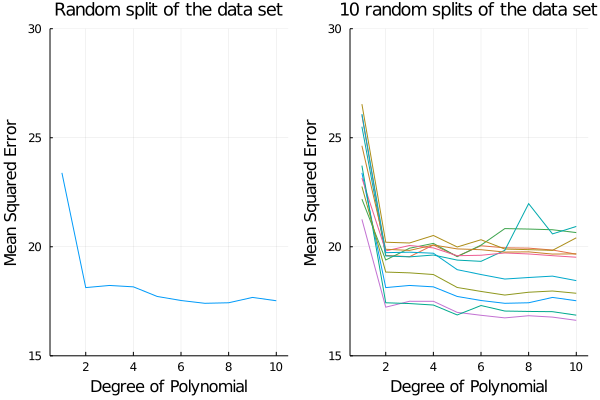

In [8]:
# Plot
plot(plot_1, plot_2)

### Figure 5.4

In [9]:
mse_o = zeros(num_splits)

# LeaveOneOut CV
for i in 1:nrow(df1)
    idxs = collect(1:nrow(df1))
    popat!(idxs, i)
    train = df1[idxs, :]
    validate = df1[[i], :]
    mse_o = mse_o + getMSE(train, validate)
end

mse_o = mse_o / nrow(df1);

In [10]:
idxs = collect(1:nrow(df1))
num_fold = 10
batch_size = nrow(df1) ÷ num_fold
num_row = nrow(df1)

mse_k = zeros(num_splits, num_fold-1)

# k-fold CV
for i in 1:(num_fold-1)
    shuffle!(idxs)
    for j in 1:num_splits
        start_idx = (j - 1) * batch_size + 1
        finish_idx = j * batch_size
        if j == 10
            finish_idx = num_row
        end
        validate = df1[idxs[start_idx:finish_idx], :]
        rest = collect(1:num_row)
        splice!(rest, collect(start_idx:finish_idx))
        train = df1[idxs[rest], :]
        mse_k[:, i] = mse_k[:, i] + getMSE(train, validate)
    end
end

mse_k = mse_k ./ num_fold;

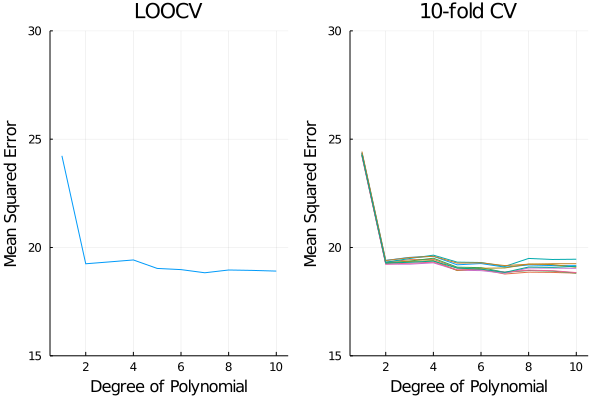

In [11]:
#plot

p1 = plot(mse_o, xlabel="Degree of Polynomial", ylabel="Mean Squared Error")
plot!(legend=false, title="LOOCV")
plot!(markershape = :circle, lc="blue", markercolor = :blue)
plot!(xlim=(0.5,10.5), ylim=(15,30))

p2 = plot(mse_k, xlabel="Degree of Polynomial", ylabel="Mean Squared Error")
plot!(legend=false, title="10-fold CV")
plot!(xlim=(0.5,10.5), ylim=(15,30))

plot(p1, p2)